# LSTM Strategy 

### References
https://www.datacamp.com/tutorial/lstm-python-stock-market

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import numpy as np

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, confusion_matrix

import yfinance as yf
from backtesting import Strategy, Backtest 
from backtesting.lib import crossover

/Users/alexandramcadam/Documents/Uni/Year4/QuantProject/quantenv/lib/python3.9/site-packages/backtesting/_plotting.py:50: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

In [132]:
#get stock data 
aapl = yf.Ticker("AAPL") #Apple Inc. 
data = aapl.history(start="2000-01-01", end="2020-01-01")

In [133]:
data.keys()

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits'], dtype='object')

In [134]:
data.index

DatetimeIndex(['2000-01-03 00:00:00-05:00', '2000-01-04 00:00:00-05:00',
               '2000-01-05 00:00:00-05:00', '2000-01-06 00:00:00-05:00',
               '2000-01-07 00:00:00-05:00', '2000-01-10 00:00:00-05:00',
               '2000-01-11 00:00:00-05:00', '2000-01-12 00:00:00-05:00',
               '2000-01-13 00:00:00-05:00', '2000-01-14 00:00:00-05:00',
               ...
               '2019-12-17 00:00:00-05:00', '2019-12-18 00:00:00-05:00',
               '2019-12-19 00:00:00-05:00', '2019-12-20 00:00:00-05:00',
               '2019-12-23 00:00:00-05:00', '2019-12-24 00:00:00-05:00',
               '2019-12-26 00:00:00-05:00', '2019-12-27 00:00:00-05:00',
               '2019-12-30 00:00:00-05:00', '2019-12-31 00:00:00-05:00'],
              dtype='datetime64[ns, America/New_York]', name='Date', length=5031, freq=None)

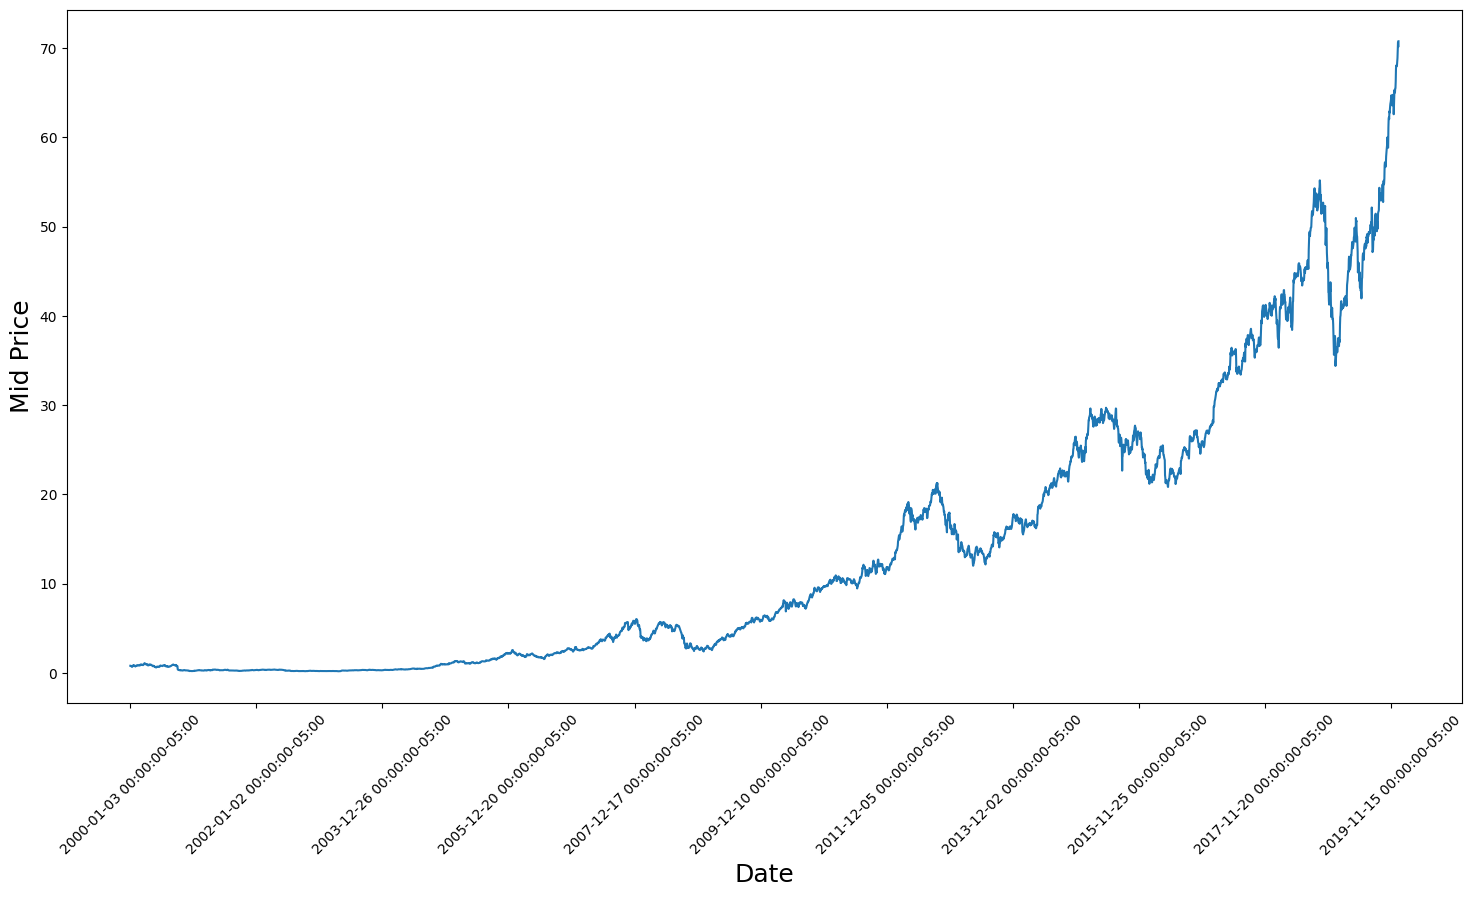

In [135]:
plt.figure(figsize = (18,9))
plt.plot(range(data.shape[0]),(data['Low']+data['High'])/2.0)
plt.xticks(range(0,data.shape[0],500),data.index[::500],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.show()

Model

In [136]:
#add factors to input data 
window = 5 #5 days 
data['Momentum'] = data['Close'].pct_change(periods=window)

# Calculate rolling volatility
data['Volatility'] = data['Close'].rolling(window=window).std()


In [137]:
data

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Momentum,Volatility
Date,,,,,,,,,
2000-01-03 00:00:00-05:00,0.790753,0.848245,0.766719,0.844004,535796800,0.0,0.0,NaN,NaN
2000-01-04 00:00:00-05:00,0.816200,0.834108,0.762950,0.772846,512377600,0.0,0.0,NaN,NaN
2000-01-05 00:00:00-05:00,0.782270,0.833636,0.776616,0.784155,778321600,0.0,0.0,NaN,NaN
2000-01-06 00:00:00-05:00,0.800178,0.806775,0.716296,0.716296,767972800,0.0,0.0,NaN,NaN
2000-01-07 00:00:00-05:00,0.727606,0.761536,0.720066,0.750226,460734400,0.0,0.0,NaN,0.047167
...,...,...,...,...,...,...,...,...,...
2019-12-24 00:00:00-05:00,69.076406,69.124936,68.646941,68.974495,48478800,0.0,0.0,0.013766,0.587542
2019-12-26 00:00:00-05:00,69.107956,70.359966,69.078841,70.342979,93121200,0.0,0.0,0.036355,1.018800
2019-12-27 00:00:00-05:00,70.636583,71.328100,69.908670,70.316299,146266000,0.0,0.0,0.034926,1.074367


In [138]:
# Drop NaN values in X (first window)
data = data[window:]
data

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Momentum,Volatility
Date,,,,,,,,,
2000-01-10 00:00:00-05:00,0.769075,0.770960,0.714411,0.737031,505064000,0.0,0.0,-0.126745,0.027251
2000-01-11 00:00:00-05:00,0.723365,0.749284,0.682366,0.699331,441548800,0.0,0.0,-0.095122,0.032578
2000-01-12 00:00:00-05:00,0.716296,0.720066,0.652206,0.657390,976068800,0.0,0.0,-0.161658,0.036225
2000-01-13 00:00:00-05:00,0.712408,0.744570,0.697446,0.729491,1032684800,0.0,0.0,0.018421,0.037081
2000-01-14 00:00:00-05:00,0.753995,0.770960,0.749283,0.757294,390376000,0.0,0.0,0.009421,0.038866
...,...,...,...,...,...,...,...,...,...
2019-12-24 00:00:00-05:00,69.076406,69.124936,68.646941,68.974495,48478800,0.0,0.0,0.013766,0.587542
2019-12-26 00:00:00-05:00,69.107956,70.359966,69.078841,70.342979,93121200,0.0,0.0,0.036355,1.018800
2019-12-27 00:00:00-05:00,70.636583,71.328100,69.908670,70.316299,146266000,0.0,0.0,0.034926,1.074367


In [139]:
#choose features 
feature_data = data[['Close', 'Momentum', 'Volatility']]

#normalise data 
scaler = MinMaxScaler()
feature_data_scaled = scaler.fit_transform(feature_data)

In [140]:
#split data into training and test sets
train_size = 0.8  # 80% training, 20% testing
train_data, test_data = train_test_split(feature_data_scaled, train_size=train_size, shuffle=False)

#define the sequence length 
sequence_length = 60
X, y = [], []

#convert to numpy 
train_data_np = train_data

#create sequences for X and target for y
for i in range(sequence_length, len(train_data_np)):
    # X includes all features from train_data_np over the sequence length
    X.append(train_data_np[i - sequence_length:i])  # Shape (sequence_length, num_features)
    
    # y uses only the 'Close' price as the target value
    y.append(train_data_np[i, 0])  # Only the 'Close' column

#convert X and y to numpy arrays
X, y = np.array(X), np.array(y)

# Reshape X for LSTM input (samples, sequence_length, features)
X = np.reshape(X, (X.shape[0], X.shape[1], X.shape[2]))

print("X shape:", X.shape)  # Expected shape: (samples, sequence_length, num_features)
print("y shape:", y.shape)  # Expected shape: (samples,)


X shape: (3960, 60, 3)
y shape: (3960,)


In [141]:
# LSTM model
n_features =  X.shape[2]

# need to tune hyperparameters and experiemnt with numbers of layers, activation function, lr 
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], n_features)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error') #add early stopping 

# Train the model
model.fit(X, y, epochs=20, batch_size=32)


Epoch 1/20


/Users/alexandramcadam/Documents/Uni/Year4/QuantProject/quantenv/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0033
Epoch 2/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 3.6481e-04
Epoch 3/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 3.3135e-04
Epoch 4/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 3.1553e-04
Epoch 5/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 2.3585e-04
Epoch 6/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 2.0485e-04
Epoch 7/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 2.0022e-04
Epoch 8/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.7713e-04
Epoch 9/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 1.8252e-04
Epoch 10/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.5254e-04
Epoch 11/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 1.6014e-04
Epoch 12/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.7199e-04
Epoch 13/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.6441e-04
Epoch 14/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.3306e-04
Ep

In [142]:
# Prepare test sequences
X_test, y_test = [], []

test_data_np = test_data

#create sequences for X and target for y
for i in range(sequence_length, len(test_data_np)):
    # X includes all features from train_data_np over the sequence length
    X_test.append(test_data_np[i - sequence_length:i])  # Shape (sequence_length, num_features)
    
    # y uses only the 'Close' price as the target value
    y_test.append(test_data_np[i, 0])  # Only the 'Close' column
    
X_test, y_test = np.array(X_test), np.array(y_test)
X = np.reshape(X, (X.shape[0], X.shape[1], X.shape[2]))

# Predict and inverse scale the results
predictions = model.predict(X_test)


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


In [143]:
len(test_data), len(X_test)

(1006, 946)

In [144]:
test_data

array([[0.33340065, 0.63278986, 0.14971947],
       [0.32497617, 0.61742222, 0.23591914],
       [0.31856197, 0.5775508 , 0.26589855],
       ...,
       [0.9868529 , 0.69995176, 0.48857247],
       [0.99272619, 0.70928696, 0.38668717],
       [1.        , 0.69888632, 0.38363479]])

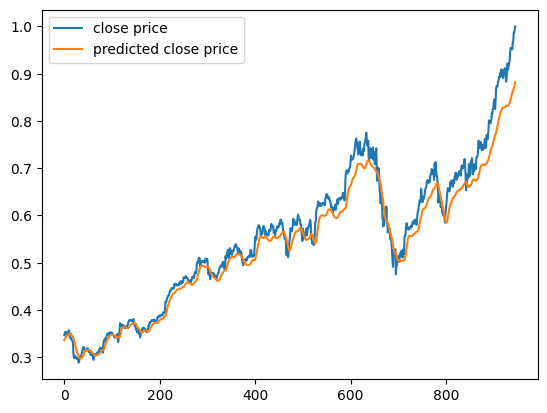

In [145]:
plt.plot(y_test, label='close price')
plt.plot(predictions, label='predicted close price')
plt.legend()

In [146]:
#model evaluation
mse = (1/len(predictions))*((np.concatenate(predictions) - y_test**2))
print(f"MSE: {mse.mean():0.10f} (+/- {mse.std():0.10f})")

MSE: 0.0002147644 (+/- 0.0000619689)


Reasonable prediction -> try doing further into future

In [81]:
# Example thresholds 
buy_threshold = 0.005  # 0.2% predicted increase
sell_threshold = -0.005  # 0.2% predicted decrease
predicted_prices = predictions
signals = []
for i in range(len(predicted_prices) - 1):
    predicted_change = (predicted_prices[i+1] - predicted_prices[i]) / predicted_prices[i]
    
    if predicted_change > buy_threshold:
        signals.append("Buy")
    elif predicted_change < sell_threshold:
        signals.append("Sell")
    else:
        signals.append("Hold")


In [82]:
# Set parameters
initial_capital = 100000
capital = initial_capital
positions = 0  # Number of shares held
transaction_fee = 0.001  # 0.1% per transaction

actual_prices = test_data[:,0]

portfolio_values = []

# Simulate strategy
for i, signal in enumerate(signals):
    current_price = actual_prices[i]

    if signal == "Buy" and positions == 0:
        positions = (capital * (1 - transaction_fee)) / current_price
        capital = 0
    elif signal == "Sell" and positions > 0:
        capital = positions * current_price * (1 - transaction_fee)
        positions = 0

    # Update portfolio value
    portfolio_value = capital if positions == 0 else positions * current_price
    portfolio_values.append(portfolio_value)

# Calculate performance
roi = (portfolio_values[-1] - initial_capital) / initial_capital
print("Final Portfolio Value:", portfolio_values[-1])
print("Return on Investment (ROI):", roi * 100, "%")


Final Portfolio Value: 191237.2040978639
Return on Investment (ROI): 91.2372040978639 %


In [155]:
#scale back predictions - check this 
unscaled_predictions = scaler.inverse_transform(np.hstack((predictions, np.zeros((predictions.shape[0], 2)))))[:, 0]

In [158]:
unscaled_predictions[:20] #when did this scale back? 

array([24.08010607, 24.21260217, 24.37043242, 24.54416746, 24.66720454,
       24.76739345, 24.81556943, 24.83125822, 24.82488869, 24.84261455,
       24.90035118, 24.99590693, 25.0589755 , 25.06225344, 25.01938612,
       24.94538897, 24.828876  , 24.69384098, 24.55893724, 24.42186516])

In [159]:
#use all columns 
unscaled_train_data, unscaled_test_data = train_test_split(data, train_size=train_size, shuffle=False)

unscaled_test_data = unscaled_test_data[sequence_length:] #predictions start after sequence length i.e. 60 or 60+1? might need to shift by 1

#predictions = scaler.inverse_transform(predictions)
unscaled_test_data['Predicted'] = unscaled_predictions #this is scaled need to inverse scale 

In [160]:
unscaled_test_data

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Momentum,Volatility,Predicted
Date,,,,,,,,,,
2016-03-31 00:00:00-04:00,25.012672,25.053706,24.821178,24.846254,103553600,0.0,0.0,0.026948,0.443620,24.080106
2016-04-01 00:00:00-04:00,24.798381,25.076503,24.666159,25.074223,103496000,0.0,0.0,0.040882,0.441083,24.212602
2016-04-04 00:00:00-04:00,25.172243,25.575747,25.138047,25.331821,149424800,0.0,0.0,0.056374,0.289160,24.370432
2016-04-05 00:00:00-04:00,24.964797,25.242918,24.944279,25.033186,106314800,0.0,0.0,0.019781,0.178343,24.544167
2016-04-06 00:00:00-04:00,25.128933,25.299909,24.894125,25.295349,105616400,0.0,0.0,0.012778,0.200069,24.667205
...,...,...,...,...,...,...,...,...,...,...
2019-12-24 00:00:00-05:00,69.076406,69.124936,68.646941,68.974495,48478800,0.0,0.0,0.013766,0.587542,61.678436
2019-12-26 00:00:00-05:00,69.107956,70.359966,69.078841,70.342979,93121200,0.0,0.0,0.036355,1.018800,61.884438
2019-12-27 00:00:00-05:00,70.636583,71.328100,69.908670,70.316299,146266000,0.0,0.0,0.034926,1.074367,62.182519


In [173]:
class LSTMThresholdStrategy(Strategy):
    BUY_THRESHOLD = 0.005  
    SELL_THRESHOLD = -0.005  

    def init(self):
        # Store predicted price change as an indicator for ease of access
        self.predicted_change = self.I(self.calculate_predicted_change, name='percentage change')

    def calculate_predicted_change(self):
        # Calculate the percentage change between consecutive predicted prices
        
        p_change =  ( self.data['Predicted'] - self.data['Close'] ) / self.data['Close'] 
        p_change = p_change*100 
        
        return p_change

    def next(self):
        # Check if the predicted change exceeds the buy threshold
        if self.predicted_change[-1] > BUY_THRESHOLD:
            self.buy()
        
        # Check if the predicted change is below the sell threshold
        elif self.predicted_change[-1] < SELL_THRESHOLD:
            self.sell()

### Step 3: Run the Backtest
# Backtesting expects a DataFrame with a DateTime index; ensure your data is set up correctly
#data.index = pd.to_datetime(data.index)  # Replace with your actual date index if needed
bt = Backtest(unscaled_test_data, LSTMThresholdStrategy, cash=10000, commission=0.001)

# Run the backtest
output = bt.run()
print(output)

# Plot results
bt.plot()


Start                     2016-03-31 00:00...
End                       2019-12-31 00:00...
Duration                   1370 days 01:00:00
Exposure Time [%]                   99.788584
Equity Final [$]                 33308.118704
Equity Peak [$]                  33960.317236
Return [%]                         233.081187
Buy & Hold Return [%]              186.765296
Return (Ann.) [%]                   37.784192
Volatility (Ann.) [%]               33.072726
Sharpe Ratio                         1.142458
Sortino Ratio                        2.364941
Calmar Ratio                         0.981305
Max. Drawdown [%]                  -38.504035
Avg. Drawdown [%]                   -3.028752
Max. Drawdown Duration      372 days 00:00:00
Avg. Drawdown Duration       22 days 00:00:00
# Trades                                   11
Win Rate [%]                            100.0
Best Trade [%]                     221.122852
Worst Trade [%]                      2.202495
Avg. Trade [%]                    

/Users/alexandramcadam/Documents/Uni/Year4/QuantProject/quantenv/lib/python3.9/site-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
/Users/alexandramcadam/Documents/Uni/Year4/QuantProject/quantenv/lib/python3.9/site-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
/Users/alexandramcadam/Documents/Uni/Year4/QuantProject/quantenv/lib/python3.9/site-packages/backtesting/_plotting.py:455: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df2 = (df.assign(_width=1).set_index('datetime')
/Users/alexandramcadam/Documents/Uni/Year4/QuantProject/quantenv/lib/python3.9/site-packages/backtesting/_plotting.py:659: UserWarning: found multiple co

GridPlot(id='p3281', ...)

In [174]:
#optimise thresholds
stats = bt.optimize(BUY_THRESHOLD=list(np.array(range(1, 50, 1))*0.001), SELL_THRESHOLD=list(np.array(range(1, 50, 1))*0.001), maximize='Equity Final [$]')
stats


/Users/alexandramcadam/Documents/Uni/Year4/QuantProject/quantenv/lib/python3.9/site-packages/backtesting/backtesting.py:1488: UserWarning: Searching for best of 2401 configurations.
  output = _optimize_grid()
/Users/alexandramcadam/Documents/Uni/Year4/QuantProject/quantenv/lib/python3.9/site-packages/backtesting/backtesting.py:1375: UserWarning: For multiprocessing support in `Backtest.optimize()` set multiprocessing start method to 'fork'.
  warnings.warn("For multiprocessing support in `Backtest.optimize()` "


Start                     2016-03-31 00:00...
End                       2019-12-31 00:00...
Duration                   1370 days 01:00:00
Exposure Time [%]                   99.788584
Equity Final [$]                 33308.118704
Equity Peak [$]                  33960.317236
Return [%]                         233.081187
Buy & Hold Return [%]              186.765296
Return (Ann.) [%]                   37.784192
Volatility (Ann.) [%]               33.072726
Sharpe Ratio                         1.142458
Sortino Ratio                        2.364941
Calmar Ratio                         0.981305
Max. Drawdown [%]                  -38.504035
Avg. Drawdown [%]                   -3.028752
Max. Drawdown Duration      372 days 00:00:00
Avg. Drawdown Duration       22 days 00:00:00
# Trades                                   11
Win Rate [%]                            100.0
Best Trade [%]                     221.122852
Worst Trade [%]                      2.202495
Avg. Trade [%]                    

In [175]:
stats._strategy

<Strategy LSTMThresholdStrategy(BUY_THRESHOLD=0.001,SELL_THRESHOLD=0.001)>

### Model for multiday forecasting 

### More code 

In [48]:
class LSTMStrategy(Strategy):
    def init(self):
        # Predict future price movements with the LSTM model
        self.predictions = predictions 
        self.index = 0
        self.threshold = 0.02  #2% threshold -> optimise 

    def next(self): #not working atm 

        if self.index < len(self.predictions):
            current_price = self.data.Close[-1] #is this correct
            predicted_price = self.predictions[self.index]
            
            # Calculate expected return as a percentage
            expected_return = (predicted_price - current_price) / current_price
            
            # Check for buy/sell signals based on threshold
            if expected_return > self.threshold:
                if not self.position.is_long:
                    self.buy()  # Open or hold a long position
            elif expected_return < -self.threshold:
                if not self.position.is_short:
                    self.sell()  # Open or hold a short position
            else:
                # Close position if the expected return is within the threshold
                if self.position:
                    self.position.close()
            
            self.index += 1
        

# Run the backtest on example data
bt = Backtest(test_data, LSTMStrategy, cash=10000, commission=.002)
stats = bt.run()
bt.plot()



/Users/alexandramcadam/Documents/Uni/Year4/QuantProject/quantenv/lib/python3.9/site-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
/Users/alexandramcadam/Documents/Uni/Year4/QuantProject/quantenv/lib/python3.9/site-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
/Users/alexandramcadam/Documents/Uni/Year4/QuantProject/quantenv/lib/python3.9/site-packages/backtesting/_plotting.py:455: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df2 = (df.assign(_width=1).set_index('datetime')
/Users/alexandramcadam/Documents/Uni/Year4/QuantProject/quantenv/lib/python3.9/site-packages/backtesting/_plotting.py:659: UserWarning: found multiple co

GridPlot(id='p1985', ...)

In [40]:
stats

Start                     2000-01-03 00:00...
End                       2019-12-31 00:00...
Duration                   7302 days 00:00:00
Exposure Time [%]                   99.960246
Equity Final [$]                897427.712345
Equity Peak [$]                 902349.307886
Return [%]                        8874.277123
Buy & Hold Return [%]             8341.952794
Return (Ann.) [%]                   25.263534
Volatility (Ann.) [%]               52.488908
Sharpe Ratio                         0.481312
Sortino Ratio                        0.891071
Calmar Ratio                         0.308853
Max. Drawdown [%]                  -81.797794
Avg. Drawdown [%]                   -5.328314
Max. Drawdown Duration     1771 days 00:00:00
Avg. Drawdown Duration       44 days 00:00:00
# Trades                                    1
Win Rate [%]                            100.0
Best Trade [%]                    8874.826324
Worst Trade [%]                   8874.826324
Avg. Trade [%]                    

In [58]:
class FactorStrategy(Strategy):
    
    def init(self):
        # Initialize an indicator to store predictions
        self.forecasts = self.I(lambda: np.repeat(np.nan, len(self.data)), name='forecast')

    def next(self):

        # Prepare the latest feature data for prediction
        features = self.data.df.iloc[-1:][['Momentum', 'Volatility']]
        predicted_return = model.predict(features)[0]

        # Update forecast indicator for plotting
        self.forecasts[-1] = predicted_return

        # Implement buy/sell logic based on predicted return
        if predicted_return > 0:
            self.buy(size=0.5) #calculate best size 
            
        elif predicted_return < 0:
            self.sell(size=0.5)
            

# Run the backtest on training data 
bt = Backtest(test_data, FactorStrategy, cash=10000, commission=0.002)
stats = bt.run()

print(stats)
bt.plot()

TypeError: `data` must be a pandas.DataFrame with columns